In [1]:
"""
For TAs: Set TRUE to run with mini sample 
"""
MINI = True

In [2]:
if MINI:
    crypto_path = './data/crypto/BTC_1sec_MINI.csv'
    crypto_size = 100_000
    fi2010_test_days = [8]  
    fi2010_stocks = [0]
else:
    crypto_path = './data/crypto/BTC_1sec.csv'
    crypto_size = 400_000
    fi2010_test_days = [8,9,10]
    fi2010_stocks = [0,1,2,3,4]

In [3]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader
from utils.training import evaluate_model, get_model_class
from utils.fi2010_loader import Dataset_fi2010
from utils.crypto_loader import load_crypto
from models.deep_lob import DeepLOB
from models.trans_lob import TransLOB
from models.deep_trans_lob import DeepTransLOB

%load_ext autoreload
%autoreload 2

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
BATCH_SIZE = 128
WINDOW_SIZE = 100
LEVELS = 10
HORIZONS=[10, 20, 30, 50, 100]
TARGET_HORIZON = 20
LABEL_ALPHA = 5e-5

LEARNING_RATE = 1e-4
ADAM_B1 = 0.9
ADAM_B2 = 0.999
WEIGHT_DECAY= 1e-5

test_ratio = 0.3

normalizations = ["DecPre", "Zscore", "MinMax"]
model_names = ["DeepLOB", "TransLOB", "DeepTransLOB"]
# horizons = [0, 1, 2, 3, 4]

# Crypto Result

In [6]:
results_crypto = []
data_type = "crypto"
for model_name in model_names:
    mode = model_name == "DeepLOB"
    for normalization in normalizations:
        print(f"Evaluating {model_name} | {normalization}")
        train_dataset, test_dataset = load_crypto(crypto_path, LEVELS, HORIZONS, TARGET_HORIZON, LABEL_ALPHA, 
                                     normalization, test_ratio, crypto_size, WINDOW_SIZE, mode, False)
        test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        model_class = get_model_class(model_name)
        metrics = evaluate_model(model_class, model_name, data_type, normalization, test_loader, device)

        results_crypto.append({
            "model": model_name,
            "normalization": normalization,
            **metrics
        })
        
results_crypto = pd.DataFrame(results_crypto)
results_crypto.dropna()

Evaluating DeepLOB | DecPre
Evaluating DeepLOB | Zscore
Evaluating DeepLOB | MinMax
Evaluating TransLOB | DecPre
Evaluating TransLOB | Zscore
Evaluating TransLOB | MinMax
Evaluating DeepTransLOB | DecPre
Evaluating DeepTransLOB | Zscore
Model not found: ./outputs/crypto/DeepTransLOB_Zscore.pth, skipping...
Evaluating DeepTransLOB | MinMax
Model not found: ./outputs/crypto/DeepTransLOB_MinMax.pth, skipping...


,model,normalization,accuracy,f1,precision,recall
0,DeepLOB,DecPre,0.685608,0.665856,0.684978,0.663234
1,DeepLOB,Zscore,0.681025,0.662812,0.682982,0.659464
2,DeepLOB,MinMax,0.680458,0.658140,0.686535,0.655471
3,TransLOB,DecPre,0.498208,0.452949,0.506964,0.465849
4,TransLOB,Zscore,0.520033,0.478580,0.515589,0.488246
5,TransLOB,MinMax,0.462100,0.391228,0.471753,0.422969
6,DeepTransLOB,DecPre,0.751125,0.749458,0.763988,0.759161


./outputs/crypto/DeepLOB_DecPre.pkl
./outputs/crypto/DeepLOB_Zscore.pkl
./outputs/crypto/DeepLOB_MinMax.pkl
./outputs/crypto/TransLOB_DecPre.pkl
./outputs/crypto/TransLOB_Zscore.pkl
./outputs/crypto/TransLOB_MinMax.pkl
./outputs/crypto/DeepTransLOB_DecPre.pkl
./outputs/crypto/DeepTransLOB_Zscore.pkl
Skipped missing: ./outputs/crypto/DeepTransLOB_Zscore.pkl
./outputs/crypto/DeepTransLOB_MinMax.pkl
Skipped missing: ./outputs/crypto/DeepTransLOB_MinMax.pkl


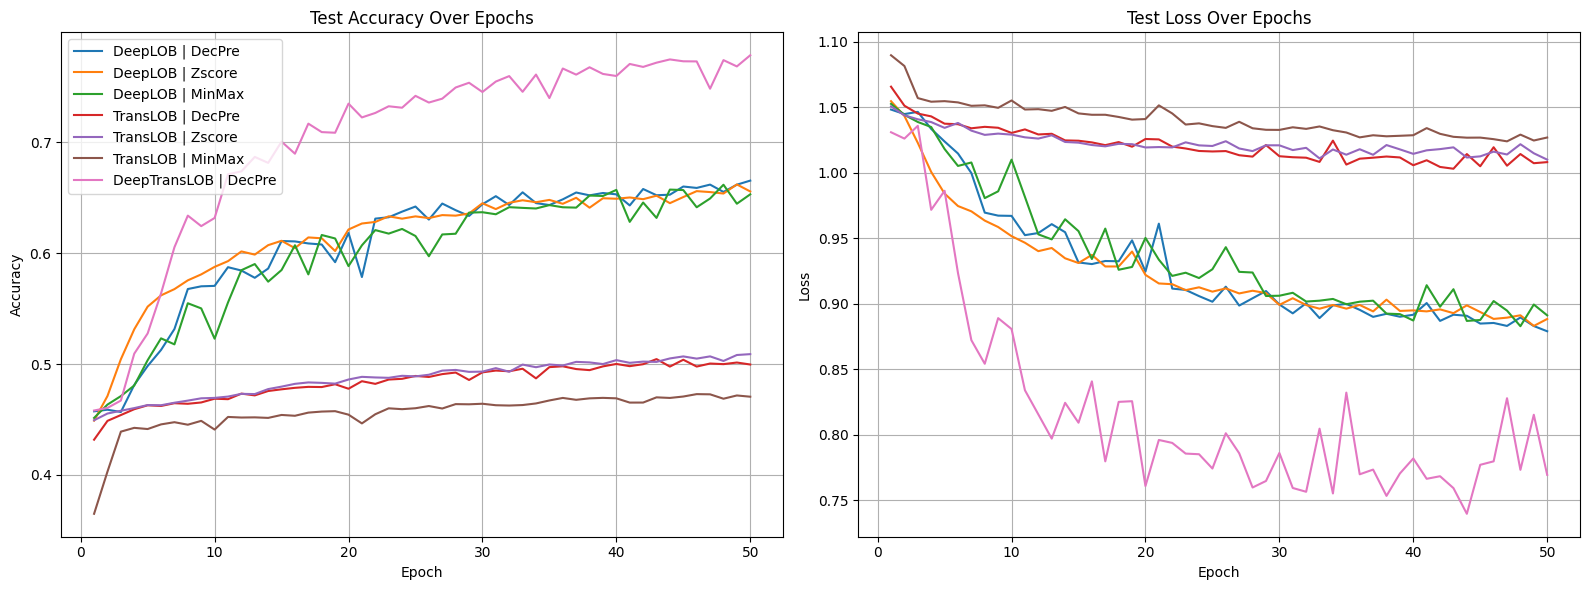

In [7]:
dataset_type = "crypto"
output_dir = f"./outputs/{dataset_type}"

fig, (ax_acc, ax_loss) = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
for model_name in model_names:
    for normalization in normalizations:
        pkl_path = os.path.join(output_dir, f"{model_name}_{normalization}.pkl")
        print(pkl_path)
        if not os.path.exists(pkl_path):
            print(f"Skipped missing: {pkl_path}")
            continue
        
        with open(pkl_path, "rb") as f:
            history = pickle.load(f)

        label = f"{model_name} | {normalization}"
        epochs = range(1, len(history['train_acc']) + 1)

        ax_acc.plot(epochs, history['val_acc'], linestyle='-', label=f"{label}")#, color=color)

        ax_loss.plot(epochs, history['val_loss'], linestyle='-', label=f"{label}")#, color=color)

ax_acc.set_title("Test Accuracy Over Epochs")
ax_acc.set_xlabel("Epoch")
ax_acc.set_ylabel("Accuracy")
ax_acc.grid(True)
ax_acc.legend()

ax_loss.set_title("Test Loss Over Epochs")
ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Loss")
ax_loss.grid(True)
# ax_loss.legend(False)

plt.tight_layout()
plt.show()


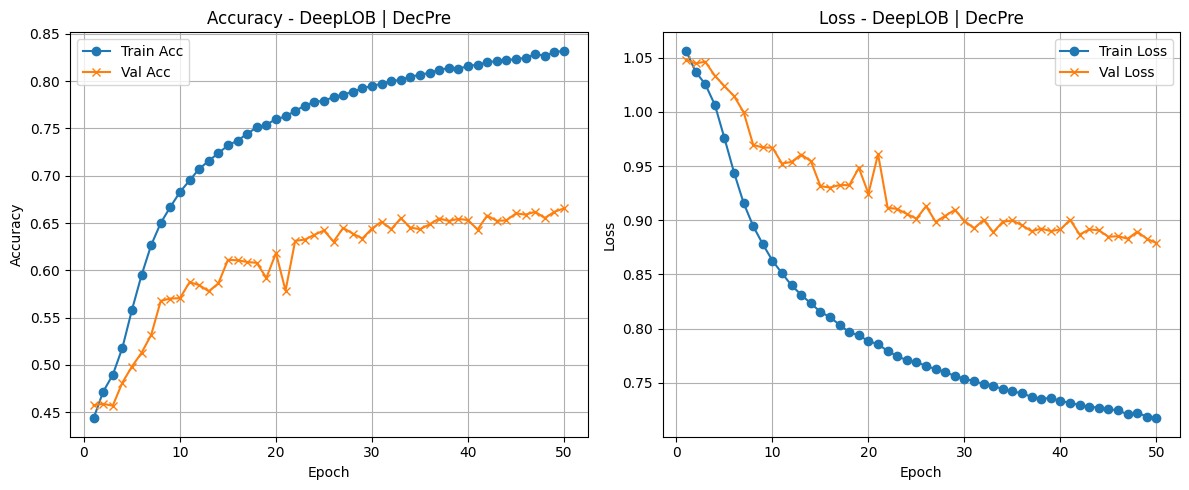

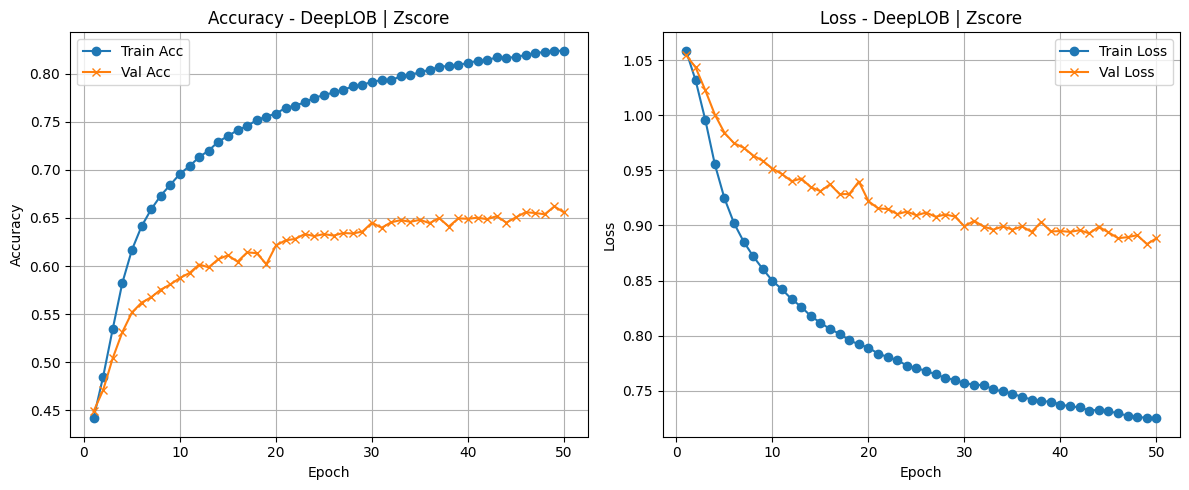

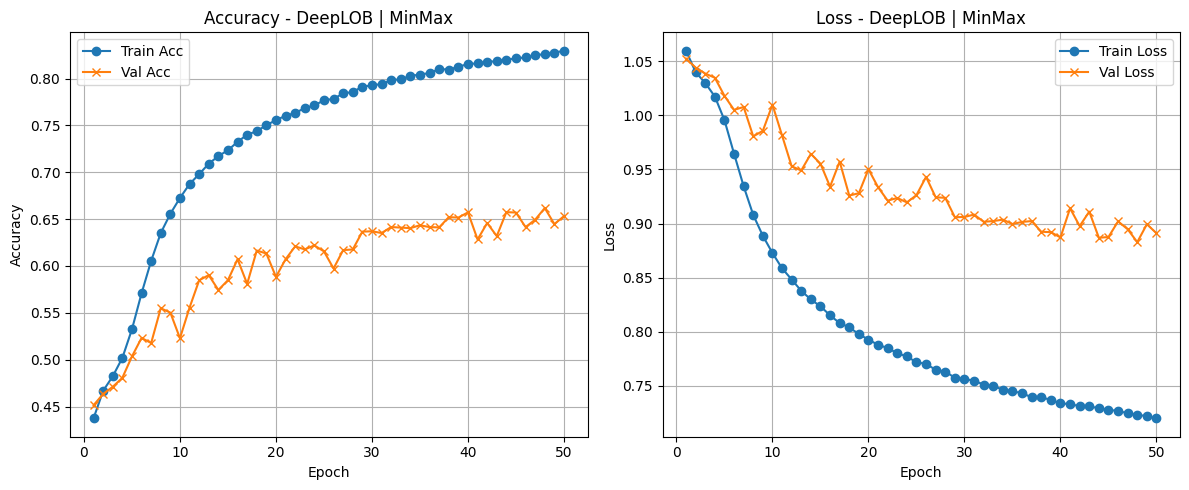

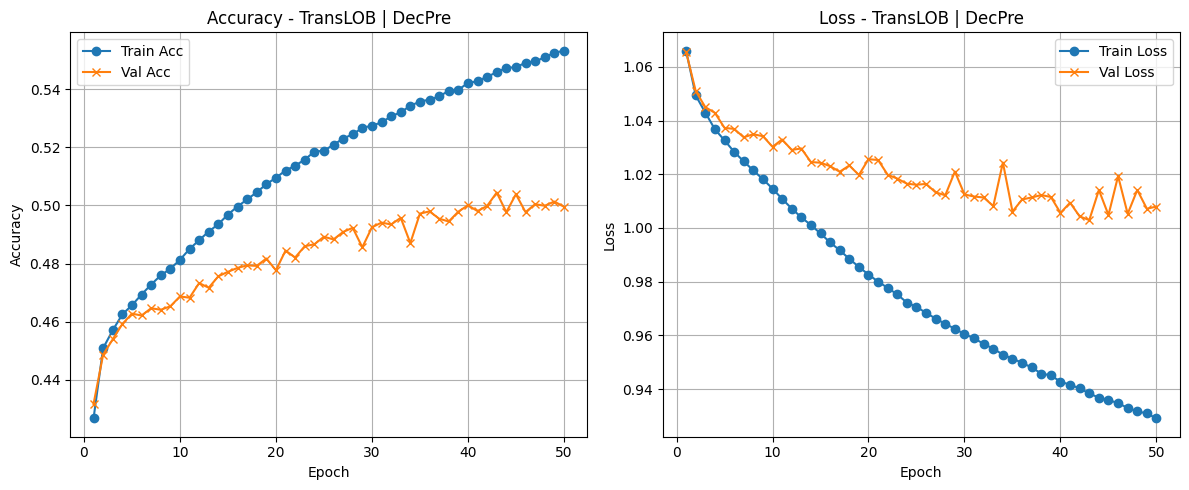

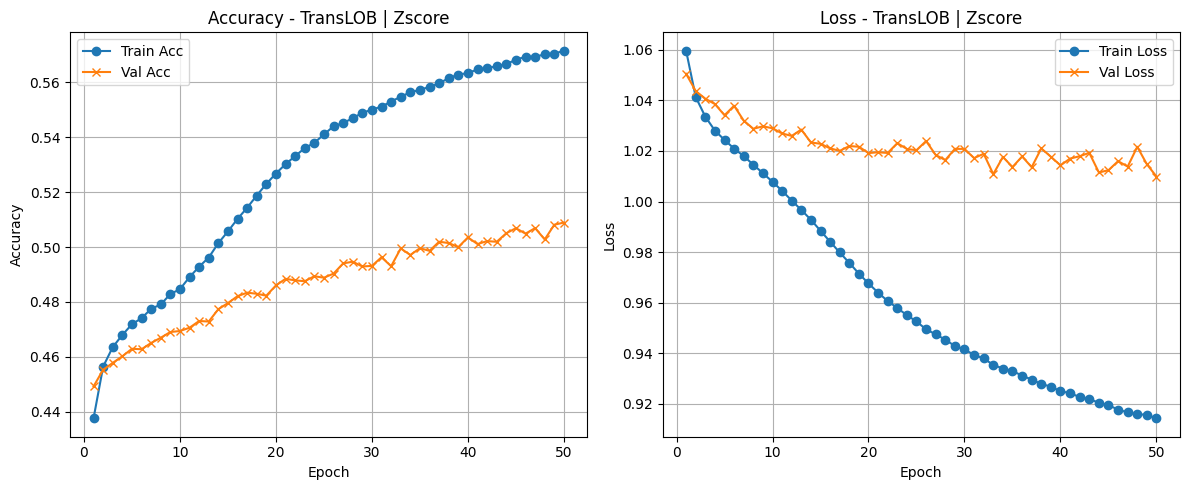

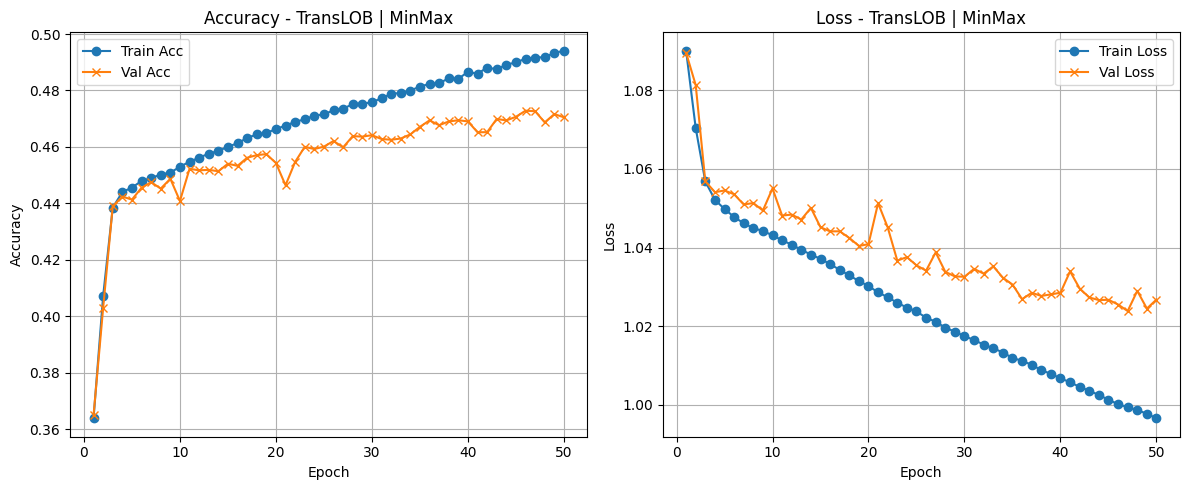

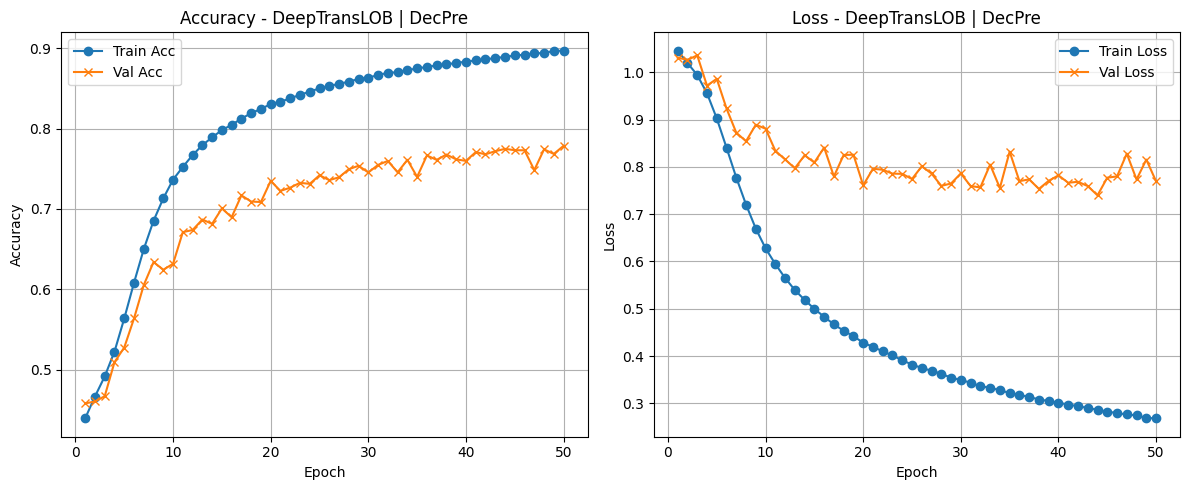

Skipped missing: ./outputs/crypto/DeepTransLOB_Zscore.pkl
Skipped missing: ./outputs/crypto/DeepTransLOB_MinMax.pkl


In [8]:
dataset_type = "crypto"
output_dir = f"./outputs/{dataset_type}"

for model_name in model_names:
    for normalization in normalizations:
        pkl_path = os.path.join(output_dir, f"{model_name}_{normalization}.pkl")
        
        if not os.path.exists(pkl_path):
            print(f"Skipped missing: {pkl_path}")
            continue
        
        with open(pkl_path, "rb") as f:
            history = pickle.load(f)

        epochs = range(1, len(history['train_acc']) + 1)

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        axs[0].plot(epochs, history['train_acc'], label="Train Acc", marker='o')
        axs[0].plot(epochs, history['val_acc'], label="Val Acc", marker='x')
        axs[0].set_title(f"Accuracy - {model_name} | {normalization}")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Accuracy")
        axs[0].legend()
        axs[0].grid(True)

        axs[1].plot(epochs, history['train_loss'], label="Train Loss", marker='o')
        axs[1].plot(epochs, history['val_loss'], label="Val Loss", marker='x')
        axs[1].set_title(f"Loss - {model_name} | {normalization}")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Loss")
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

# FI-2010 Results

In [9]:
data_type = "fi2010"

results_fi2010 = []
for model_name in model_names:
    for normalization in normalizations:
        print(f"Evaluating {model_name} | {normalization}")
   
        dataset_test = Dataset_fi2010(False, normalization, fi2010_stocks, fi2010_test_days, WINDOW_SIZE, 4, model_name=="DeepLOB", False)
        test_loader =  DataLoader(dataset=dataset_test, batch_size=128, shuffle=False, num_workers=4)
        model_class = get_model_class(model_name)
        metrics = evaluate_model(model_class, model_name, data_type, normalization, test_loader, device)

        results_fi2010.append({
            "model": model_name,
            "normalization": normalization,
            **metrics
        })

results_fi2010 = pd.DataFrame(results_fi2010)
results_fi2010.dropna()

Evaluating DeepLOB | DecPre
Evaluating DeepLOB | Zscore
Evaluating DeepLOB | MinMax
Evaluating TransLOB | DecPre
Evaluating TransLOB | Zscore
Evaluating TransLOB | MinMax
Evaluating DeepTransLOB | DecPre
Evaluating DeepTransLOB | Zscore
Model not found: ./outputs/fi2010/DeepTransLOB_Zscore.pth, skipping...
Evaluating DeepTransLOB | MinMax
Model not found: ./outputs/fi2010/DeepTransLOB_MinMax.pth, skipping...


,model,normalization,accuracy,f1,precision,recall
0,DeepLOB,DecPre,0.743660,0.742934,0.744192,0.742375
1,DeepLOB,Zscore,0.741930,0.741285,0.741755,0.741081
2,DeepLOB,MinMax,0.741322,0.740030,0.740719,0.739714
3,TransLOB,DecPre,0.634632,0.634573,0.650233,0.632358
4,TransLOB,Zscore,0.665964,0.666651,0.670932,0.665874
5,TransLOB,MinMax,0.640860,0.640933,0.642776,0.640215
6,DeepTransLOB,DecPre,0.737752,0.737521,0.737774,0.737783


Skipped missing: ./outputs/fi2010/DeepTransLOB_Zscore.pkl
Skipped missing: ./outputs/fi2010/DeepTransLOB_MinMax.pkl


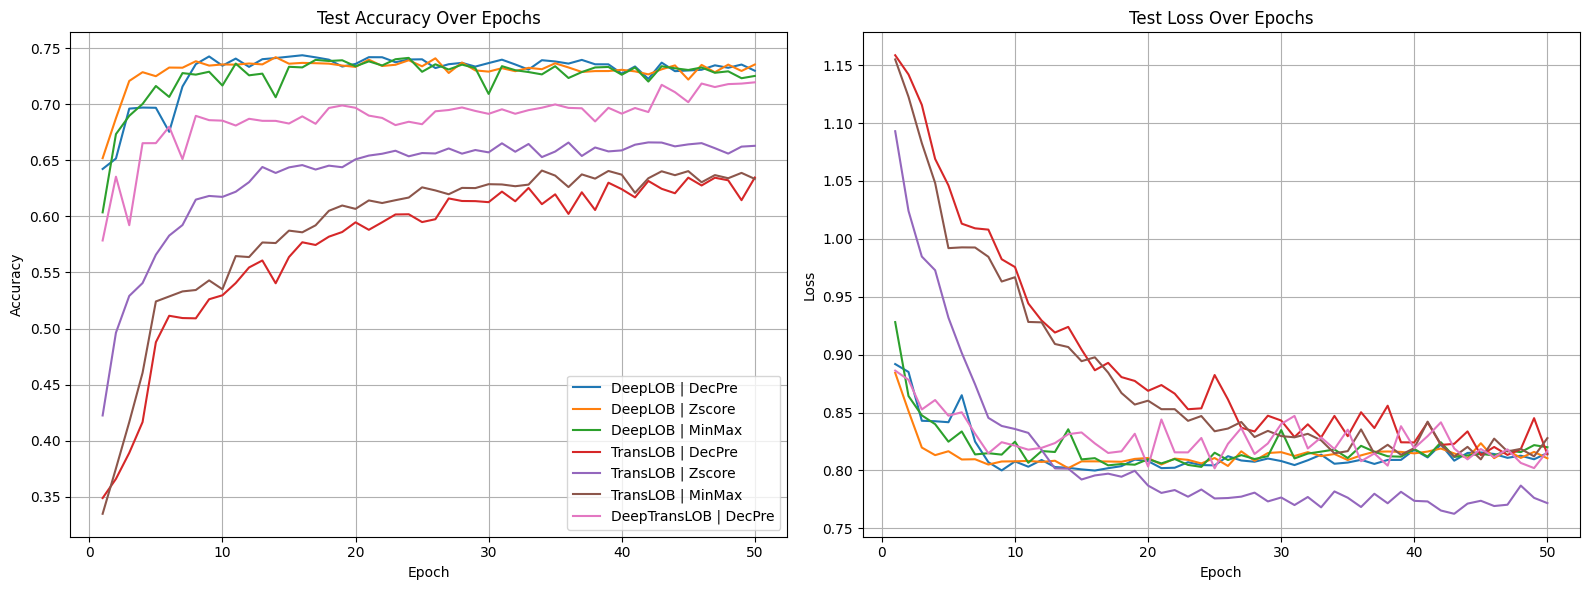

In [10]:
dataset_type = "fi2010"
output_dir = f"./outputs/{dataset_type}"

fig, (ax_acc, ax_loss) = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
for model_name in model_names:
    for normalization in normalizations:
        pkl_path = os.path.join(output_dir, f"{model_name}_{normalization}.pkl")
        if not os.path.exists(pkl_path):
            print(f"Skipped missing: {pkl_path}")
            continue
        
        with open(pkl_path, "rb") as f:
            history = pickle.load(f)

        label = f"{model_name} | {normalization}"
        epochs = range(1, len(history['train_acc']) + 1)

        ax_acc.plot(epochs, history['val_acc'], linestyle='-', label=f"{label}")#, color=color)

        ax_loss.plot(epochs, history['val_loss'], linestyle='-', label=f"{label}")#, color=color)

ax_acc.set_title("Test Accuracy Over Epochs")
ax_acc.set_xlabel("Epoch")
ax_acc.set_ylabel("Accuracy")
ax_acc.grid(True)
ax_acc.legend()

ax_loss.set_title("Test Loss Over Epochs")
ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Loss")
ax_loss.grid(True)
# ax_loss.legend()

plt.tight_layout()
plt.show()


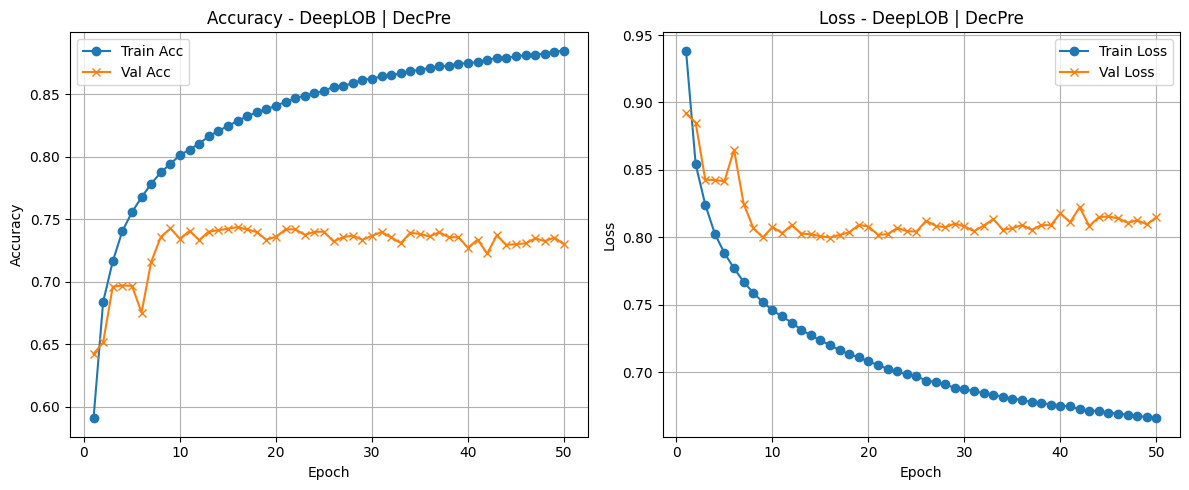

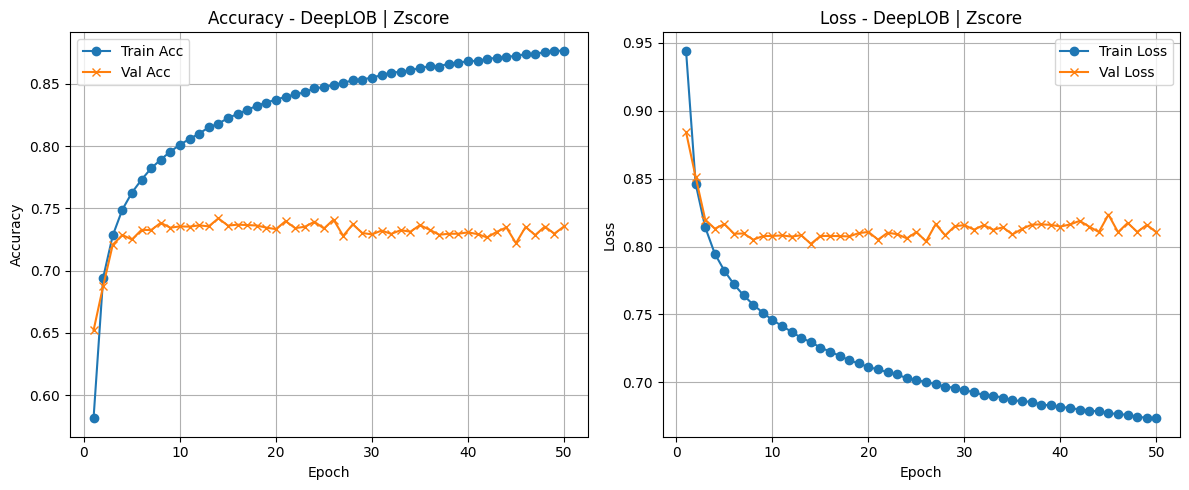

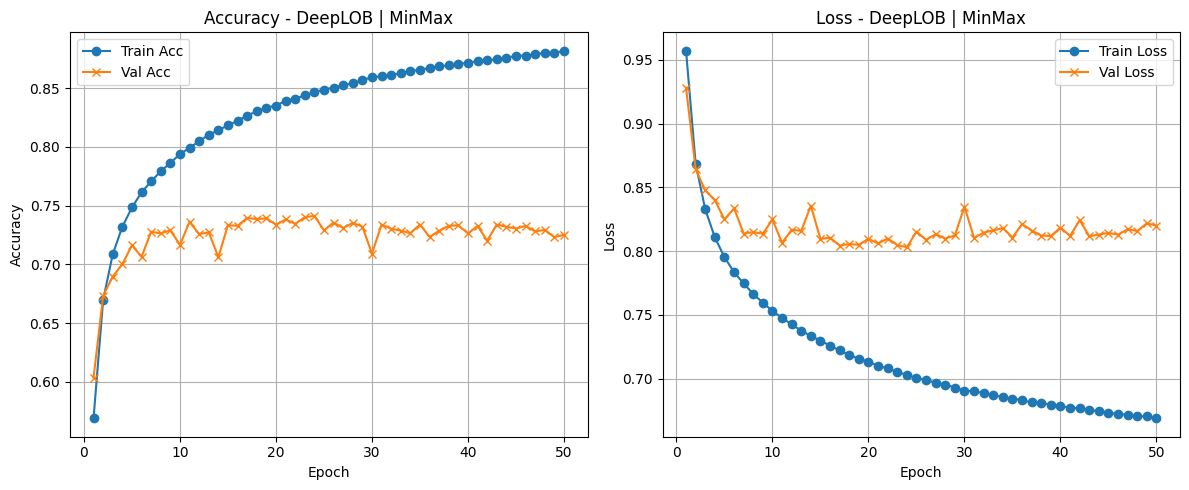

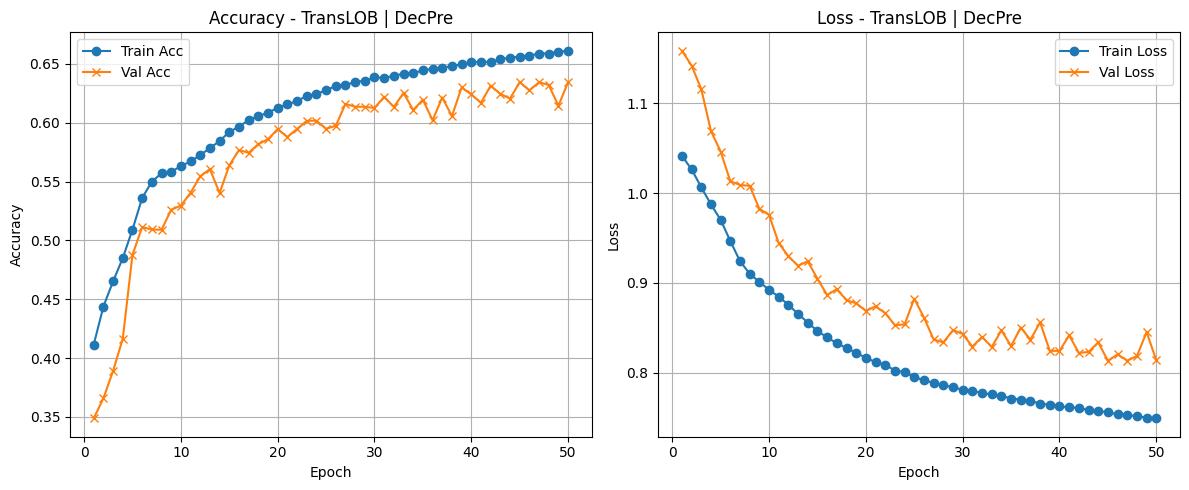

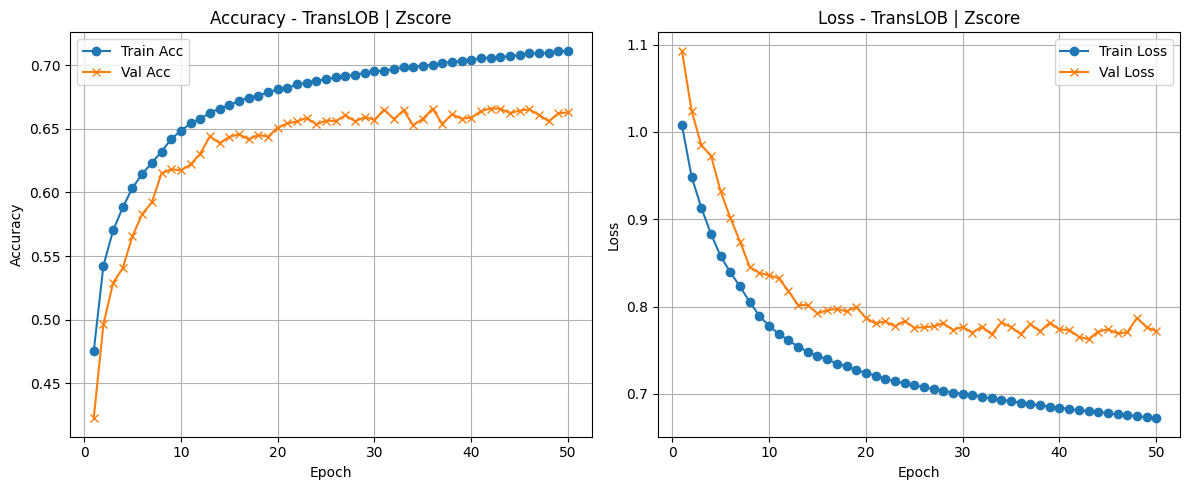

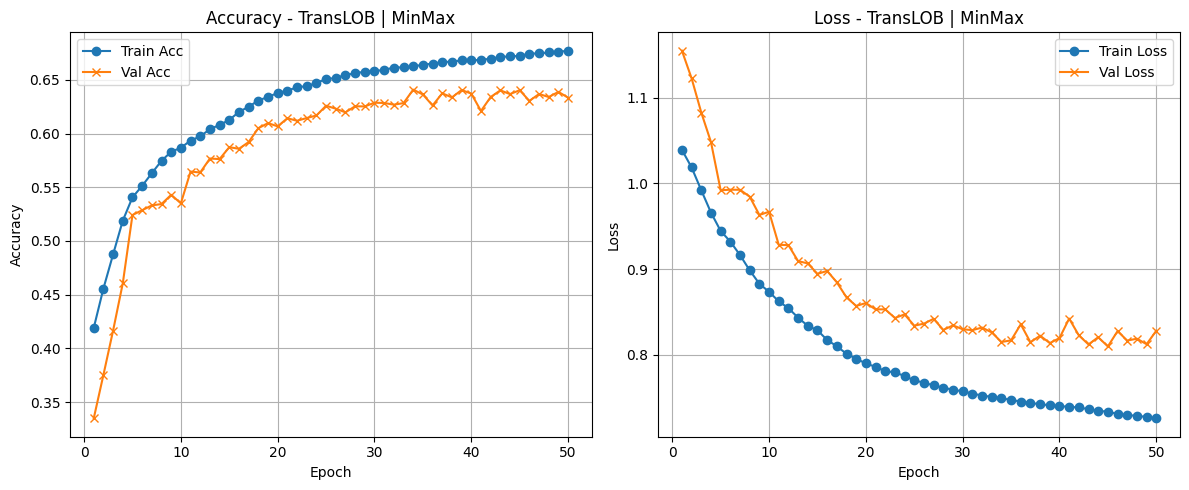

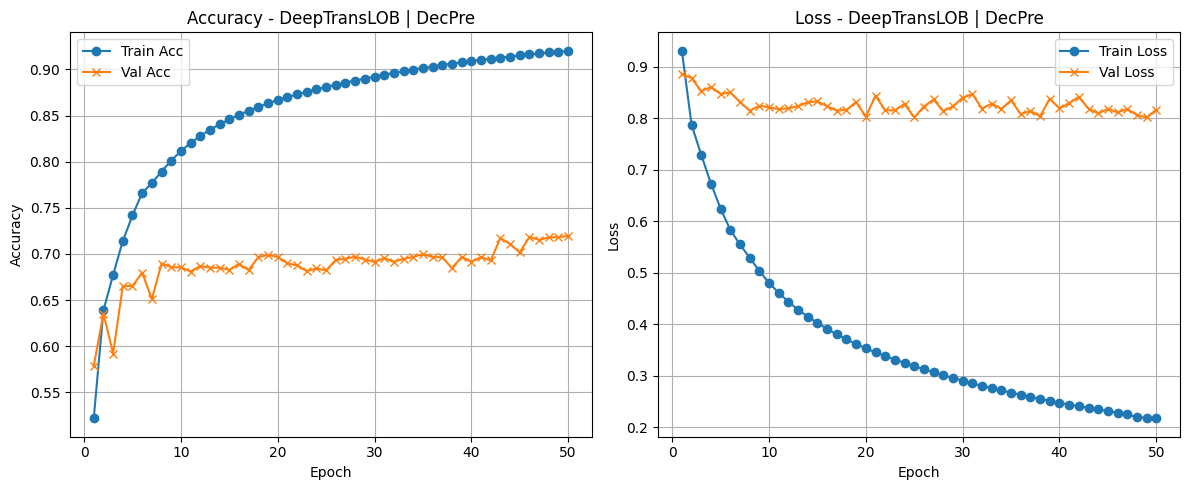

Skipped missing: ./outputs/fi2010/DeepTransLOB_Zscore.pkl
Skipped missing: ./outputs/fi2010/DeepTransLOB_MinMax.pkl


In [11]:
dataset_type = "fi2010"
output_dir = f"./outputs/{dataset_type}"

for model_name in model_names:
    for normalization in normalizations:
        pkl_path = os.path.join(output_dir, f"{model_name}_{normalization}.pkl")
        
        if not os.path.exists(pkl_path):
            print(f"Skipped missing: {pkl_path}")
            continue
        
        with open(pkl_path, "rb") as f:
            history = pickle.load(f)

        epochs = range(1, len(history['train_acc']) + 1)

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        axs[0].plot(epochs, history['train_acc'], label="Train Acc", marker='o')
        axs[0].plot(epochs, history['val_acc'], label="Val Acc", marker='x')
        axs[0].set_title(f"Accuracy - {model_name} | {normalization}")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Accuracy")
        axs[0].legend()
        axs[0].grid(True)

        axs[1].plot(epochs, history['train_loss'], label="Train Loss", marker='o')
        axs[1].plot(epochs, history['val_loss'], label="Val Loss", marker='x')
        axs[1].set_title(f"Loss - {model_name} | {normalization}")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("Loss")
        axs[1].legend()
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()